<img src="https://upload.wikimedia.org/wikipedia/fr/8/81/Sciences_SU.png" width="240" height="240" align="center"/>


# MLA 703. RNN-LSTM et architectures avancées [Analyse de sentiment]

In [1]:
# Dans ce notebook, nous allons nous intéresser à des tâches d'analyse de sentiments
# -> c'est à dire prédire un label de sentiment (ici positif ou négatif) à partir d'un texte

# Ce notebook vise à approfondir : 
# - L'application du DL sur des données textuelles
# - La compréhension des architectures RNN avancées comme les LSTM et les mécanismes d'attention
#

# 1. Importation des modules

In [2]:
# On importe les librairies usuelless
import math
import numpy as np
import matplotlib.pyplot as plt

# On désactive les warnings
import warnings
warnings.filterwarnings('ignore')


## 1. Charger les données

## 2. Formater/Préparer les données

In [3]:
# On charge directement la base IMDB par les datasets de Keras
# La méthode load_date possède pas mal d'options et de propriétés intéressantes (voir description) :
# 1) Sépare les jeux d'entrainement et de test
# 2) num_words : Top most frequent words to consider.
# 3) skip_top : Top most frequent words to ignore (they will appear as oov_char value in the sequence data).
# 4) maxlen : Maximum sequence length. Any longer sequence will be truncated.
# 5) seed : Seed for reproducible data shuffling.
# 6) start_char : The start of a sequence will be marked with this character. Set to 1 because 0 is usually the padding character.
# 7) oov_char : words that were cut out because of the num_words or skip_top limit will be replaced with this character.
# 8) index_from : Index actual words with this index and higher.

from tensorflow.keras.datasets import imdb

num_words = 5000
max_len   =  100

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words, maxlen=max_len)
                                            

In [4]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# On padde les séquences

print("La phrase avant padding est : \n {}". format(x_train[0]))

# On padde les séquence de mot
max_len       = 100
x_train       = pad_sequences(x_train, maxlen=max_len, truncating='post')
x_test        = pad_sequences(x_test, maxlen=max_len, truncating='post')

print("La phrase paddée sur une longueur {} est : \n {}". format(max_len, x_train[0]))
      
print(len(x_train))    

La phrase avant padding est : 
 [1, 778, 128, 74, 12, 630, 163, 15, 4, 1766, 2, 1051, 2, 32, 85, 156, 45, 40, 148, 139, 121, 664, 665, 10, 10, 1361, 173, 4, 749, 2, 16, 3804, 8, 4, 226, 65, 12, 43, 127, 24, 2, 10, 10]
La phrase paddée sur une longueur 100 est : 
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    1  778  128   74   12  630  163   15    4 1766    2 1051    2
   32   85  156   45   40  148  139  121  664  665   10   10 1361  173
    4  749    2   16 3804    8    4  226   65   12   43  127   24    2
   10   10]
2773


## 3. Déclaration du réseau

La tâche consiste à prédire la valence d'un texte à partir de son contenu.
Pour ce faire nous allons créer une architecture many-to-one 
avec les réseaux RNNs
Le problème consiste à implémenter et apprendre
des réseaux avec - par exemple - les configurations suivantes : 
On va comparer les configurations suivantes : 
- Simple RNN avec dropout (avec un taux de 25% en sortie du RNN)
- RNN-LSTM gauche-droite classique
- LSTM bi-directionnel et return_sequences = False
- Plusieurs couches au choix. On veillera en particulier 
  à la valeur des arguments return_sequences
  
Dans le rapport à faire directement dans le notebook, on prendra soin de :
- reporter les losses sur les ensembles d'entrainement et de validation
- mesurer l'accuracy sur l'ensemble de test
On commentera les résultats obtenus en comparant les configurations
Quelle est la configuration donnant la meilleure performance ? 
Pourquoi ?

Aide : une couche LSTM bi-directionnelle est obtenue en appliquant sur la même couche une couche LSTM et une couche Bidirectional

In [5]:
# On importe les librairies pour le RNN
from tensorflow.keras.layers import Dense , Input , SimpleRNN, LSTM , Embedding, Dropout
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Convolution1D
#from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

embed_size = 128                                                   # dimension de l'embedding
RNN_size   = 64

# Example d'architecture pour le réseau RNN simple avec dropout
model = Sequential()
model.add(Embedding(num_words, embed_size))                 # layer embedding
model.add(SimpleRNN(RNN_size, return_sequences = False))    # layer RNN
model.add(Dropout(0.25))                                    # layer Dropout
model.add(Dense(1))                                         # layer Dense

# On affiche l'architecture de notre modèle
model.summary()

# On spécifie la fonction de perte, l'optimiseur, et la fonction d'évaluation
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         640000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                12352     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 652,417
Trainable params: 652,417
Non-trainable params: 0
_________________________________________________________________


## 4. Entrainement du réseau

In [6]:
# On entraine le réseau
batch_size = 64                                                             # tailles des mini-batch
epochs = 10                                                                 # nombre d'époques
history = model.fit(x_train,y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2) # on entraine

Epoch 1/10
35/35 [==============================] - 2s 23ms/step - loss: 2.0361 - accuracy: 0.5068 - val_loss: 0.6756 - val_accuracy: 0.5838
Epoch 2/10
35/35 [==============================] - 1s 18ms/step - loss: 1.0225 - accuracy: 0.6456 - val_loss: 0.8545 - val_accuracy: 0.5279
Epoch 3/10
35/35 [==============================] - 1s 18ms/step - loss: 0.4088 - accuracy: 0.8634 - val_loss: 1.0579 - val_accuracy: 0.5171
Epoch 4/10
35/35 [==============================] - 1s 18ms/step - loss: 0.1620 - accuracy: 0.9626 - val_loss: 1.5523 - val_accuracy: 0.5676
Epoch 5/10
35/35 [==============================] - 1s 17ms/step - loss: 0.0665 - accuracy: 0.9946 - val_loss: 1.6593 - val_accuracy: 0.5640
Epoch 6/10
35/35 [==============================] - 1s 18ms/step - loss: 0.0348 - accuracy: 0.9964 - val_loss: 1.9315 - val_accuracy: 0.5730
Epoch 7/10
35/35 [==============================] - 1s 18ms/step - loss: 0.0278 - accuracy: 0.9982 - val_loss: 1.9119 - val_accuracy: 0.5784
Epoch 8/10
35

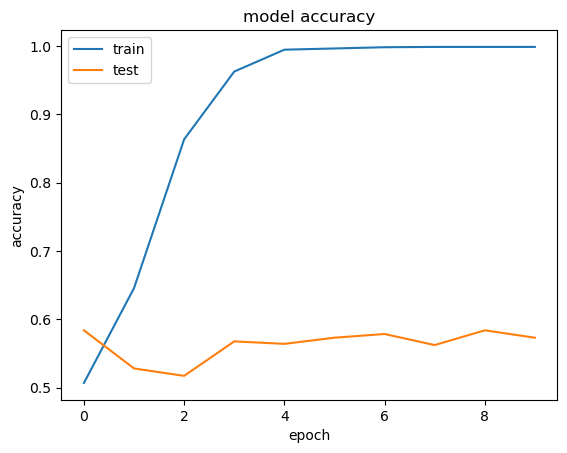

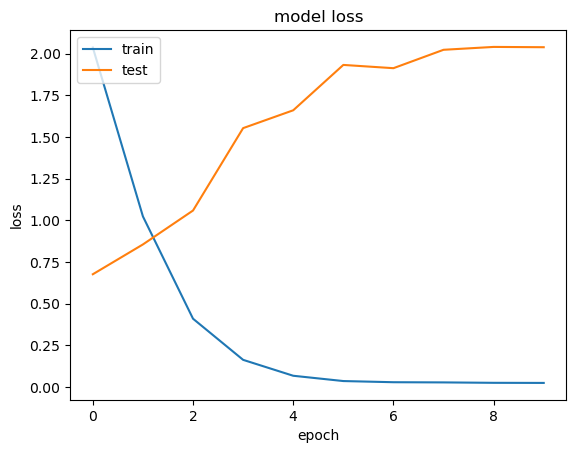

In [7]:
# On trace la loss et l'accuracy du modèle
# On trace l'évolution de l'accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy']) 
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# On trace l'évolution de la loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [8]:
history

# On prédit sur l'ensemble de test

# On prédit sur les données de test
y_hat = model.predict(x_test)

# On tranforme les prédictions en labels
i_pos = [i for i in range(len(y_hat)) if y_hat[i]>0]
i_neg = [i for i in range(len(y_hat)) if y_hat[i]<=0]

y_pred   = np.zeros(len(y_hat))
y_pred[i_pos] = 1
y_pred[i_neg] = 0


93/93 [==============================] - 0s 4ms/step


In [9]:
# On importe les librairies pour l'évaluation
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix

# On calcule la matrice de confusion
cm_test = confusion_matrix(y_test, y_pred)
print('La matrice de confusion sur le jeu de test :\n', cm_test, '\n')

# On calcul le score d accuracy
acc_train=accuracy_score(y_test, y_pred)
print('L accuracy sur le jeu de test est :\n', acc_train)


La matrice de confusion sur le jeu de test :
 [[ 253 1106]
 [ 159 1445]] 

L accuracy sur le jeu de test est :
 0.5730678366520419
